# Running the (R-based) HIV branching process from Python

This notebook shows how to run the R-based HIV simulator code based on abranching process from Python. The wrapper to the simulator is the `simulate_transmission` function that is coded in the `hiv_branching_process.R` file. To illustrate how the Python-R interface works, we first run the testing script within the R file, and then call the `simulate_transmission` function directly using different sets of parameters. 

## Initialization

We first load standard Python packages, along with the `rpy2` package that allows us to call R code. We should also set the working directory to make sure that the paths within the simulators will work.

In [1]:
# Standard packages
import os
%matplotlib inline

In [2]:
# R-related packages
import rpy2
import rpy2.robjects as robjects
r = robjects.r

# We may need to install some packages
try:
    from rpy2.robjects.packages import importr
    dplyr = importr('dplyr')
except RRuntimeError:
    from rpy2.robjects.packages import importr, data
    utils = importr('utils')
    base = importr('base')
    utils.chooseCRANmirror()
    utils.install_packages('dplyr')

In [3]:
# Set up working directory
cwd = os.getcwd()
os.chdir('../')

## Run `hiv_branching_process.R`'s testing function

In [4]:
r.source('hiv_branching_process.R')

value,[RTYPES.NILSXP]
visible,[RTYPES.LGLSXP]


## Calling `simulate_transmission` from Python

Once we source `hiv_branching_process.R`, we can access `simulate_transmission()`. We can define (or modify default) parameters in the function call. This function returns a named list with two items: `population_summary` and `transmission_record`. We can convert each of those items into pandas dataframes, and process that data directly in Python.

In [5]:
out = r.simulate_transmission( sim_time=100 )

  |==================================================| 100%


In [6]:
# Convert simulator outputs into Pandas dataframes
population_summary_r  = out.rx2('population_summary' )
transmission_record_r = out.rx2('transmission_record')

from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
with localconverter( robjects.default_converter + pandas2ri.converter ):
    population_summary  = robjects.conversion.rpy2py( population_summary_r  )
    transmission_record = robjects.conversion.rpy2py( transmission_record_r )

We can now explore the simulation output:

In [7]:
population_summary.head()

,recipient,removal_rate,partners,acts_per_day,transmission_risk_per_act,transmission_risk_per_day,source,infectionTime,sampleTime,cumulative_partners,cumulative_transmissions
1,1.0,0.001,0,0.152823,0.95,0.000000,0.0,0.0,365.0,0.0,0.0
2,2.0,0.001,1,0.072246,0.95,0.000110,0.0,0.0,365.0,0.0,0.0
3,3.0,0.001,0,0.522873,0.95,0.000000,0.0,0.0,365.0,0.0,0.0
4,4.0,0.001,2,0.854449,0.95,0.003289,0.0,0.0,365.0,0.0,0.0
5,5.0,0.001,0,0.577191,0.95,0.000000,0.0,0.0,365.0,0.0,0.0


In [8]:
transmission_record.head()

,recipient,timestep,removal,transmission
1,1.0,100,True,False
2,2.0,100,False,False
3,3.0,100,False,False
4,4.0,100,False,False
5,5.0,100,False,False


<Axes: xlabel='infectionTime'>

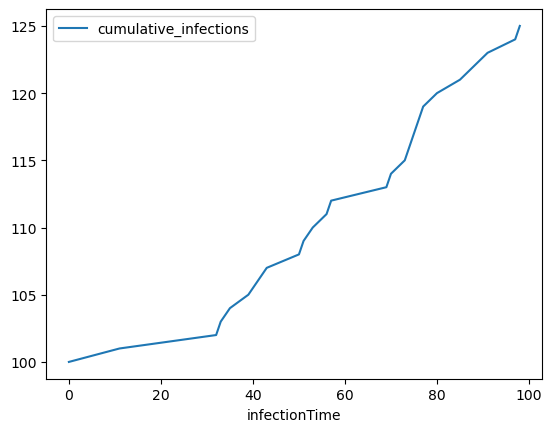

In [9]:
infection_events = population_summary.groupby('infectionTime').count().rename(columns={'recipient':'count'})
infection_events['cumulative_infections'] = infection_events['count'].cumsum()
infection_events = infection_events.loc[:, ['count', 'cumulative_infections']]
infection_events.plot( y='cumulative_infections' )